In [1]:
import warnings
warnings.filterwarnings('ignore')

### Decision Trees: практика

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 500

In [3]:
df = pd.read_csv('cut_market_info.csv')
df.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,month,dcoilwtico,city,state,type,cluster,family,class,perishable,holiday_type,locale,locale_name,description,transferred
0,2016-10-26,6,1489881,6.000,1.0,2016-10,48.75,Quito,Pichincha,D,13,PRODUCE,2018,1,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
1,2014-06-02,9,953609,7.000,0.0,2014-06,103.07,Quito,Pichincha,B,6,CLEANING,3046,0,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
2,2017-06-18,21,1946155,5.000,0.0,2017-06,44.73,Santo Domingo,Santo Domingo de los Tsachilas,B,6,DELI,2650,1,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
3,2016-07-09,46,119023,6.000,0.0,2016-07,45.37,Quito,Pichincha,A,14,CLEANING,3026,0,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
4,2016-08-04,43,760319,7.707,0.0,2016-08,41.92,Esmeraldas,Esmeraldas,E,10,POULTRY,2416,1,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay


In [4]:
X = df.drop("unit_sales", axis=1)
y = df["unit_sales"]

### Будем считать MSLE

y = y.apply(np.log1p)

### Отделим валидацию от теста по времени!

X_test, X_train = X[X.date >= '2017-06-01'], X[X.date < '2017-06-01']

y_test, y_train = y[y.index.isin(X_test.index)], y[y.index.isin(X_train.index)]

### Уберем колонку с датой

X_test = X_test.drop('date', axis=1)
X_train = X_train.drop('date', axis=1)
X = X.drop('date', axis=1)

object_cols = ['store_nbr', 'item_nbr', 'onpromotion', 'month',
               'city', 'state', 'type', 'cluster', 'family',
               'class', 'perishable', 'holiday_type', 'locale',
               'locale_name', 'description', 'transferred']

X[object_cols] = X[object_cols].astype(object)
X_test[object_cols] = X_test[object_cols].astype(object)
X_train[object_cols] = X_train[object_cols].astype(object)


X.head()

,store_nbr,item_nbr,onpromotion,month,dcoilwtico,city,state,type,cluster,family,class,perishable,holiday_type,locale,locale_name,description,transferred
0,6,1489881,1.0,2016-10,48.75,Quito,Pichincha,D,13,PRODUCE,2018,1,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
1,9,953609,0.0,2014-06,103.07,Quito,Pichincha,B,6,CLEANING,3046,0,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
2,21,1946155,0.0,2017-06,44.73,Santo Domingo,Santo Domingo de los Tsachilas,B,6,DELI,2650,1,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
3,46,119023,0.0,2016-07,45.37,Quito,Pichincha,A,14,CLEANING,3026,0,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay
4,43,760319,0.0,2016-08,41.92,Esmeraldas,Esmeraldas,E,10,POULTRY,2416,1,WorkingDay,WorkingDay,WorkingDay,WorkingDay,WorkingDay


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
splitter = TimeSeriesSplit(n_splits=3)

### Дерево

In [ ]:
### Кастомные трансформеры - это круто,
### но на больших данных необходимо задумываться
### об оптимизации и векторных вычислениях
### Будем трансформировать колонки уже готовыми реализациями


In [ ]:
### Запишем заранее колонки для OHE
### и счетчиков
### а также вещественные колонки


cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]
numeric_cols = list(X_train.select_dtypes(exclude='object').columns)

### сохраним индексы этих колонок

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]
numeric_cols_idx = [list(X_train.columns).index(col) for col in numeric_cols]

In [ ]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler

t = [('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
     ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx),
     ('StandardScaler', StandardScaler(), numeric_cols_idx)]

col_transform = ColumnTransformer(transformers=t)

In [ ]:
col_transform.fit(X_train, y_train)

ColumnTransformer(transformers=[('OneHotEncoder', OneHotEncoder(), [2, 11, 13]),
                                ('MeanTargetEncoder', TargetEncoder(),
                                 [0, 1, 3, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16]),
                                ('StandardScaler', StandardScaler(), [4])])

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

pipe_dt = Pipeline([("column_transformer",
                     col_transform),

                    ("decision_tree",
                     DecisionTreeRegressor())])

pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [2, 11, 13]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [0, 1, 3, 5, 6, 7, 8, 9, 10,
                                                   12, 14, 15, 16]),
                                                 ('StandardScaler',
                                                  StandardScaler(), [4])])),
                ('decision_tree', DecisionTreeRegressor())])

In [ ]:
### Замерим качество работы такой модели
###

train_preds = pipe_dt.predict(X_train)
test_preds = pipe_dt.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error.round(3)}")
print(f"Качество на тесте: {test_error.round(3)}")

Качество на трейне: 0.0
Качество на тесте: 0.843


In [ ]:
### Попробуем контролировать обобщающую способность такой модели!

from sklearn.model_selection import GridSearchCV

param_grid = {
    "decision_tree__max_depth": [3, 5, 10],
    "decision_tree__min_samples_split": [10, 200, 50000],
    "decision_tree__min_impurity_decrease": [0, 0.1],
    "decision_tree__max_leaf_nodes": [100, 1000]
}

### Передадим в GridSearchCV

search = GridSearchCV(pipe_dt,
                      param_grid,
                      cv=splitter,
                      scoring='neg_mean_squared_error',
                      verbose=10)

search.fit(X_train, y_train)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {search.score(X_test, y_test)}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3; 1/36] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 1/3; 1/36] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-0.539 total time=   1.0s
[CV 2/3; 1/36] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 2/3; 1/36] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-0.524 total time=   1.6s
[CV 3/3; 1/36] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 3/3; 1/36] END decision_tree__max_depth=3, decision_tree__max_leaf_nod

### Обучение стекинга

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor

pipe_dt = Pipeline([("column_transformer",
                     col_transform),

                    ("decision_tree",
                     DecisionTreeRegressor())])

pipe_lr = Pipeline([("column_transformer",
                     col_transform),

                    ("Lasso",
                     Lasso())])

pipe_knn = Pipeline([("column_transformer",
                      col_transform),

                     ("knn",
                      KNeighborsRegressor())])

estimators = [
    ("dt", pipe_dt),
    ("lr", pipe_lr),
    ("knn", pipe_knn)
]

final_estimator = DecisionTreeRegressor(max_depth=3)

### Base learners are fitted on the full X
### while the final estimator is trained
### using cross-validated predictions of the base learners
### using cross_val_predict.

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=2
)

In [ ]:
stacking_model.fit(X_train, y_train)

StackingRegressor(cv=2,
                  estimators=[('dt',
                               Pipeline(steps=[('column_transformer',
                                                ColumnTransformer(transformers=[('OneHotEncoder',
                                                                                 OneHotEncoder(),
                                                                                 [2,
                                                                                  11,
                                                                                  13]),
                                                                                ('MeanTargetEncoder',
                                                                                 TargetEncoder(),
                                                                                 [0,
                                                                                  1,
                                                                                  3,
                                                                                  5,
                                                                                  6,
                                                                                  7,
                                                                                  8,
                                                                                  9,
                                                                                  10,
                                                                                  12,
                                                                                  14,
                                                                                  15,
                                                                                  16]),
                                                                                ('StandardScaler',
                                                                                 StandardScaler(),
                                                                                 [4])])),
                                               ('decision_tree',
                                                DecisionTreeRegressor())])),
                              ('lr',
                               Pipeline(steps=[('column_trans...
                                                                                 StandardScaler(),
                                                                                 [4])])),
                                               ('Lasso', Lasso())])),
                              ('knn',
                               Pipeline(steps=[('column_transformer',
                                                ColumnTransformer(transformers=[('OneHotEncoder',
                                                                                 OneHotEncoder(),
                                                                                 [2,
                                                                                  11,
                                                                                  13]),
                                                                                ('MeanTargetEncoder',
                                                                                 TargetEncoder(),
                                                                                 [0,
                                                                                  1,
                                                                                  3,
                                                                                  5,
                                                                                  6,
                                                                                  7,
                                      

In [ ]:
### Замерим качество работы такой модели
### Возьмем MSLE

train_preds = stacking_model.predict(X_train)
test_preds = stacking_model.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error.round(3)}")
print(f"Качество на тесте: {test_error.round(3)}")

Качество на трейне: 0.315
Качество на тесте: 0.512


### Обучение бэггинга

In [ ]:
from sklearn.ensemble import BaggingRegressor

base_pipe = Pipeline([("column_transformer",
                       col_transform),

                     ("decision_tree",
                      DecisionTreeRegressor(max_depth=10))])

bagging = BaggingRegressor(estimator=base_pipe,
                            n_estimators=10, random_state=32)

bagging.fit(X_train, y_train)

BaggingRegressor(estimator=Pipeline(steps=[('column_transformer',
                                            ColumnTransformer(transformers=[('OneHotEncoder',
                                                                             OneHotEncoder(),
                                                                             [2,
                                                                              11,
                                                                              13]),
                                                                            ('MeanTargetEncoder',
                                                                             TargetEncoder(),
                                                                             [0,
                                                                              1,
                                                                              3,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              9,
                                                                              10,
                                                                              12,
                                                                              14,
                                                                              15,
                                                                              16]),
                                                                            ('StandardScaler',
                                                                             StandardScaler(),
                                                                             [4])])),
                                           ('decision_tree',
                                            DecisionTreeRegressor(max_depth=10))]),
                 random_state=32)

In [ ]:
### Замерим качество работы такой модели
### Возьмем MSLE

train_preds = bagging.predict(X_train)
test_preds = bagging.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error.round(3)}")
print(f"Качество на тесте: {test_error.round(3)}")

Качество на трейне: 0.402
Качество на тесте: 0.457


In [ ]:
### Построим обучающие кривые:

train_losses = []
test_losses = []

for i in range(1, 21):

    bagging = BaggingRegressor(estimator=base_pipe,
                               n_estimators=i, random_state=32)

    bagging.fit(X_train, y_train)

    train_preds = bagging.predict(X_train)
    test_preds = bagging.predict(X_test)

    train_error = np.mean((train_preds - y_train)**2)
    test_error = np.mean((test_preds - y_test)**2)

    train_losses.append(train_error)
    test_losses.append(test_error)

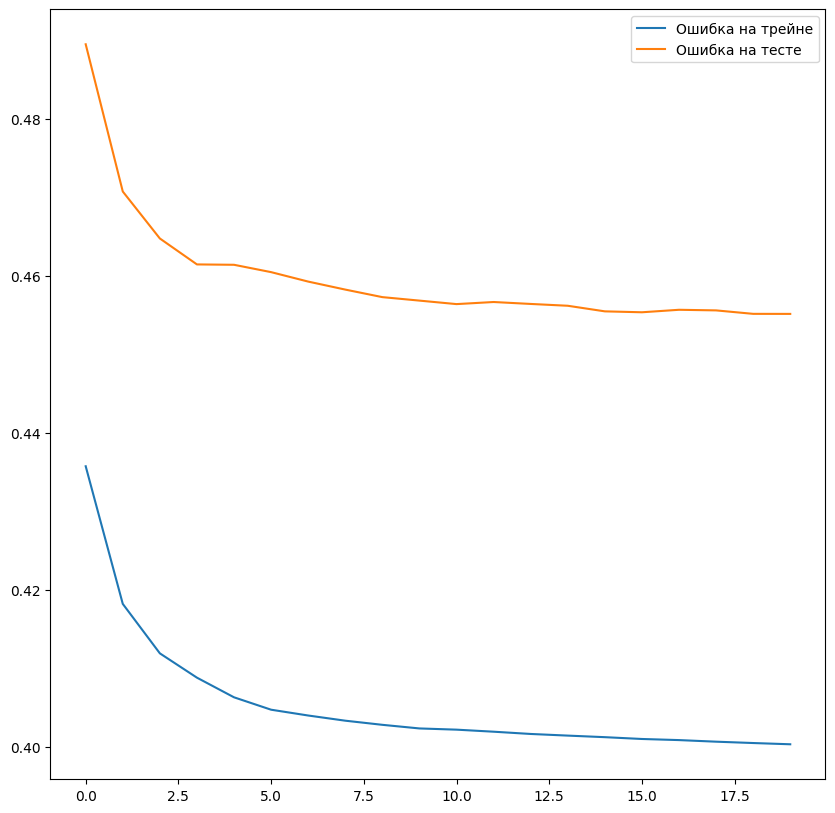

In [ ]:
fig = plt.figure()
fig.set_size_inches(10, 10)

plt.plot(train_losses)
plt.plot(test_losses)

plt.legend(['Ошибка на трейне', 'Ошибка на тесте'])
plt.show()

### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RandomForest_pipe = Pipeline([("column_transformer",
                               col_transform),

                              ("decision_tree",
                               RandomForestRegressor(max_depth=10,
                                                     verbose=1))])

RandomForest_pipe.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   41.5s


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [2, 11, 13]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [0, 1, 3, 5, 6, 7, 8, 9, 10,
                                                   12, 14, 15, 16]),
                                                 ('StandardScaler',
                                                  StandardScaler(), [4])])),
                ('decision_tree',
                 RandomForestRegressor(max_depth=10, verbose=1))])

In [ ]:
### Замерим качество работы такой модели
### Возьмем MSLE

train_preds = RandomForest_pipe.predict(X_train)
test_preds = RandomForest_pipe.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error.round(3)}")
print(f"Качество на тесте: {test_error.round(3)}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


Качество на трейне: 0.401
Качество на тесте: 0.458


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


In [ ]:
from sklearn.model_selection import GridSearchCV

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 400, num = 3)]
max_depth = [int(x) for x in np.linspace(10, 51, num = 4)]


param_grid =  {'decision_tree__n_estimators': n_estimators,
               'decision_tree__max_depth': max_depth
              }

### Передадим в GridSearchCV

search = GridSearchCV(RandomForest_pipe,
                      param_grid,
                      cv=splitter,
                      scoring='neg_mean_squared_error',
                      verbose=10)

search.fit(X_train, y_train)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {search.score(X_test, y_test)}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START decision_tree__max_depth=10, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    9.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


[CV 1/3; 1/12] END decision_tree__max_depth=10, decision_tree__n_estimators=50;, score=-0.479 total time=  11.1s
[CV 2/3; 1/12] START decision_tree__max_depth=10, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   19.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


[CV 2/3; 1/12] END decision_tree__max_depth=10, decision_tree__n_estimators=50;, score=-0.456 total time=  22.0s
[CV 3/3; 1/12] START decision_tree__max_depth=10, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   29.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


[CV 3/3; 1/12] END decision_tree__max_depth=10, decision_tree__n_estimators=50;, score=-0.450 total time=  32.2s
[CV 1/3; 2/12] START decision_tree__max_depth=10, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    9.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   38.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.3s


[CV 1/3; 2/12] END decision_tree__max_depth=10, decision_tree__n_estimators=225;, score=-0.478 total time=  46.1s
[CV 2/3; 2/12] START decision_tree__max_depth=10, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   18.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.9s


[CV 2/3; 2/12] END decision_tree__max_depth=10, decision_tree__n_estimators=225;, score=-0.456 total time= 1.5min
[CV 3/3; 2/12] START decision_tree__max_depth=10, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   30.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.9s


[CV 3/3; 2/12] END decision_tree__max_depth=10, decision_tree__n_estimators=225;, score=-0.449 total time= 2.4min
[CV 1/3; 3/12] START decision_tree__max_depth=10, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    9.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   38.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.9s


[CV 1/3; 3/12] END decision_tree__max_depth=10, decision_tree__n_estimators=400;, score=-0.477 total time= 1.3min
[CV 2/3; 3/12] START decision_tree__max_depth=10, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   18.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.9s


[CV 2/3; 3/12] END decision_tree__max_depth=10, decision_tree__n_estimators=400;, score=-0.456 total time= 2.7min
[CV 3/3; 3/12] START decision_tree__max_depth=10, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   29.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.9s


[CV 3/3; 3/12] END decision_tree__max_depth=10, decision_tree__n_estimators=400;, score=-0.449 total time= 4.1min
[CV 1/3; 4/12] START decision_tree__max_depth=23, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   20.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s


[CV 1/3; 4/12] END decision_tree__max_depth=23, decision_tree__n_estimators=50;, score=-0.485 total time=  23.0s
[CV 2/3; 4/12] START decision_tree__max_depth=23, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   41.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


[CV 2/3; 4/12] END decision_tree__max_depth=23, decision_tree__n_estimators=50;, score=-0.454 total time=  44.8s
[CV 3/3; 4/12] START decision_tree__max_depth=23, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s


[CV 3/3; 4/12] END decision_tree__max_depth=23, decision_tree__n_estimators=50;, score=-0.440 total time= 1.1min
[CV 1/3; 5/12] START decision_tree__max_depth=23, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   21.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.0s


[CV 1/3; 5/12] END decision_tree__max_depth=23, decision_tree__n_estimators=225;, score=-0.478 total time= 1.7min
[CV 2/3; 5/12] START decision_tree__max_depth=23, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   41.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  2.8min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.6s


[CV 2/3; 5/12] END decision_tree__max_depth=23, decision_tree__n_estimators=225;, score=-0.447 total time= 3.3min
[CV 3/3; 5/12] START decision_tree__max_depth=23, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  4.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    4.2s


[CV 3/3; 5/12] END decision_tree__max_depth=23, decision_tree__n_estimators=225;, score=-0.434 total time= 5.0min
[CV 1/3; 6/12] START decision_tree__max_depth=23, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   21.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.0s


[CV 1/3; 6/12] END decision_tree__max_depth=23, decision_tree__n_estimators=400;, score=-0.477 total time= 2.9min
[CV 2/3; 6/12] START decision_tree__max_depth=23, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   41.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  2.8min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    4.2s


[CV 2/3; 6/12] END decision_tree__max_depth=23, decision_tree__n_estimators=400;, score=-0.446 total time= 5.8min
[CV 3/3; 6/12] START decision_tree__max_depth=23, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  4.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    4.5s


[CV 3/3; 6/12] END decision_tree__max_depth=23, decision_tree__n_estimators=400;, score=-0.433 total time= 8.7min
[CV 1/3; 7/12] START decision_tree__max_depth=37, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   22.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


[CV 1/3; 7/12] END decision_tree__max_depth=37, decision_tree__n_estimators=50;, score=-0.486 total time=  24.5s
[CV 2/3; 7/12] START decision_tree__max_depth=37, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   45.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s


[CV 2/3; 7/12] END decision_tree__max_depth=37, decision_tree__n_estimators=50;, score=-0.456 total time=  49.0s
[CV 3/3; 7/12] START decision_tree__max_depth=37, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s


[CV 3/3; 7/12] END decision_tree__max_depth=37, decision_tree__n_estimators=50;, score=-0.443 total time= 1.3min
[CV 1/3; 8/12] START decision_tree__max_depth=37, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   22.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.4s


[CV 1/3; 8/12] END decision_tree__max_depth=37, decision_tree__n_estimators=225;, score=-0.479 total time= 1.8min
[CV 2/3; 8/12] START decision_tree__max_depth=37, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   45.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  3.1min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    4.6s


[CV 2/3; 8/12] END decision_tree__max_depth=37, decision_tree__n_estimators=225;, score=-0.449 total time= 3.6min
[CV 3/3; 8/12] START decision_tree__max_depth=37, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  4.9min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    5.4s


[CV 3/3; 8/12] END decision_tree__max_depth=37, decision_tree__n_estimators=225;, score=-0.436 total time= 5.7min
[CV 1/3; 9/12] START decision_tree__max_depth=37, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   22.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.4s


[CV 1/3; 9/12] END decision_tree__max_depth=37, decision_tree__n_estimators=400;, score=-0.478 total time= 3.2min
[CV 2/3; 9/12] START decision_tree__max_depth=37, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   46.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  3.1min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    5.0s


[CV 2/3; 9/12] END decision_tree__max_depth=37, decision_tree__n_estimators=400;, score=-0.448 total time= 6.5min
[CV 3/3; 9/12] START decision_tree__max_depth=37, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  4.8min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.0s


[CV 3/3; 9/12] END decision_tree__max_depth=37, decision_tree__n_estimators=400;, score=-0.435 total time= 9.9min
[CV 1/3; 10/12] START decision_tree__max_depth=51, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   22.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s


[CV 1/3; 10/12] END decision_tree__max_depth=51, decision_tree__n_estimators=50;, score=-0.487 total time=  24.5s
[CV 2/3; 10/12] START decision_tree__max_depth=51, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   45.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s


[CV 2/3; 10/12] END decision_tree__max_depth=51, decision_tree__n_estimators=50;, score=-0.456 total time=  49.3s
[CV 3/3; 10/12] START decision_tree__max_depth=51, decision_tree__n_estimators=50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s


[CV 3/3; 10/12] END decision_tree__max_depth=51, decision_tree__n_estimators=50;, score=-0.443 total time= 1.3min
[CV 1/3; 11/12] START decision_tree__max_depth=51, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   22.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.3s


[CV 1/3; 11/12] END decision_tree__max_depth=51, decision_tree__n_estimators=225;, score=-0.479 total time= 1.8min
[CV 2/3; 11/12] START decision_tree__max_depth=51, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   46.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  3.1min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    4.5s


[CV 2/3; 11/12] END decision_tree__max_depth=51, decision_tree__n_estimators=225;, score=-0.449 total time= 3.6min
[CV 3/3; 11/12] START decision_tree__max_depth=51, decision_tree__n_estimators=225


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  4.9min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    5.8s


[CV 3/3; 11/12] END decision_tree__max_depth=51, decision_tree__n_estimators=225;, score=-0.436 total time= 5.7min
[CV 1/3; 12/12] START decision_tree__max_depth=51, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   22.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.9s


[CV 1/3; 12/12] END decision_tree__max_depth=51, decision_tree__n_estimators=400;, score=-0.478 total time= 3.1min
[CV 2/3; 12/12] START decision_tree__max_depth=51, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   45.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  3.1min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    4.4s


[CV 2/3; 12/12] END decision_tree__max_depth=51, decision_tree__n_estimators=400;, score=-0.448 total time= 6.4min
[CV 3/3; 12/12] START decision_tree__max_depth=51, decision_tree__n_estimators=400


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  4.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    5.6s


[CV 3/3; 12/12] END decision_tree__max_depth=51, decision_tree__n_estimators=400;, score=-0.436 total time= 9.7min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  5.7min


Best parameter (CV score=-0.45222):
{'decision_tree__max_depth': 23, 'decision_tree__n_estimators': 400}


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.2s


Качество лучшей модели на финальном тесте: -0.4414813052959652
